In [0]:
#import lib

import tensorflow as tf
import csv
import numpy as np
import PIL as Image

from keras import Model
from keras.applications.mobilenet import MobileNet , preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

In [50]:
from google.colab import drive 
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
path = '/content/drive/My Drive/Bounding_Box_reg/'

In [0]:
#Please note we will be using mobile net model for this 

ALPHA = 1.0

IMAGE_SIZE = 128

EPOCHS =10

BATCH_SIZE = 32

**Mobile Net**

Alpha: controls the width of the network.
If alpha < 1.0, proportionally decreases the number of filters in each layer.
If alpha > 1.0, proportionally increases the number of filters in each layer.
If alpha = 1, default number of filters from the paper are used at each layer.



Ref:https://arxiv.org/pdf/1704.04861.pdf 

In [0]:
train_csv = path+"train_labels.csv"

In [54]:
train_csv

'/content/drive/My Drive/Bounding_Box_reg/train_labels.csv'

In [0]:
import pandas as pd

train = pd.read_csv(train_csv)

In [70]:
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


In [56]:
print(train.head())
print(" ")
print("Shape of the training data ",train.shape)

         filename  width  height    class  xmin  ymin  xmax  ymax
0  raccoon-17.jpg    259     194  raccoon    95    60   167   118
1  raccoon-11.jpg    660     432  raccoon     3     1   461   431
2  raccoon-63.jpg    600     400  raccoon    74   107   280   290
3  raccoon-63.jpg    600     400  raccoon   227    93   403   298
4  raccoon-60.jpg    273     185  raccoon    58    33   197   127
 
Shape of the training data  (173, 8)


In [0]:
#With the help csv.reader write a for loop which can load the train.csv file and store the path,width,height,x0,y0,x1,y1 in induvidual variable

with open(train_csv,'r') as csvfile:
  paths = []
  coords = np.zeros((sum(1 for line in csvfile)-1,4))
  reader = csv.reader(csvfile,delimiter=',')
  csvfile.seek(0)
  next(reader,None)
  for col,row in enumerate(reader):
    
    for i, r in enumerate(row):
      if((i!=0) & (i!=3)):
        row[i] = int(r)
    path, image_width, image_height,_, x0, y0, x1, y1 = row    
    
    path = "/content/drive/My Drive/Bounding_Box_reg/images/" + path
    coords[col,0] = x0 * IMAGE_SIZE/image_width
    coords[col,1] = y0 * IMAGE_SIZE/image_height 
    coords[col,2] = (x1-x0) * IMAGE_SIZE/image_width
    coords[col,3] = (y1-y0) * IMAGE_SIZE/image_height
      
    paths.append(path)

In [77]:
#Loop to load all the training images into a variable 'batch_images' using the paths from paths variable

#We need to convert images to RGB as mobilenet accepts 3 channels as inputs

batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
print("First few paths",paths[0],paths[1])
for i, f in enumerate(paths):
    try :
      img = Image.open(f) # Read image
      img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
      img = img.convert('RGB')
      batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
    except :
      pass
  
 # print(batch_images)

First few paths /content/drive/My Drive/Bounding_Box_reg/images/raccoon-17.jpg /content/drive/My Drive/Bounding_Box_reg/images/raccoon-11.jpg


In [0]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet

for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)

x = Reshape((4,))(x) 

model = Model(inputs=model.input, outputs=x)

In [0]:
gt = coords

def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

In [85]:
#Compile model

model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE


model.fit(batch_images,gt,
            epochs=100,batch_size = 32,
            verbose=1)

Epoch 1/100
173/173 [==============================] - 2s 14ms/step - loss: 83.0830 - IoU: 0.8026
Epoch 2/100
173/173 [==============================] - 0s 681us/step - loss: 74.3910 - IoU: 0.7937
Epoch 3/100
173/173 [==============================] - 0s 601us/step - loss: 75.9340 - IoU: 0.7941
Epoch 4/100
173/173 [==============================] - 0s 567us/step - loss: 63.9971 - IoU: 0.7977
Epoch 5/100
173/173 [==============================] - 0s 600us/step - loss: 60.9484 - IoU: 0.8154
Epoch 6/100
173/173 [==============================] - 0s 537us/step - loss: 58.5774 - IoU: 0.8326
Epoch 7/100
173/173 [==============================] - 0s 541us/step - loss: 54.2478 - IoU: 0.8525
Epoch 8/100
173/173 [==============================] - 0s 537us/step - loss: 61.0640 - IoU: 0.8394
Epoch 9/100
173/173 [==============================] - 0s 526us/step - loss: 59.7153 - IoU: 0.8424
Epoch 10/100
173/173 [==============================] - 0s 554us/step - loss: 61.1720 - IoU: 0.8362
Epoch 11/1

In [0]:
#pick a test image from the given data 
import cv2

filename = "/content/drive/My Drive/Bounding_Box_reg/images/raccoon-145.jpg"
unscaled = cv2.imread(filename)

In [0]:
image_height,image_width,_ = unscaled.shape
image = cv2.resize(unscaled,(IMAGE_SIZE,IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image,dtype=np.float32))

In [96]:
#predictions

region = model.predict(x=np.array([feat_scaled]))[0]
print(region)

[ 12.302816   8.767719  97.85986  123.73836 ]


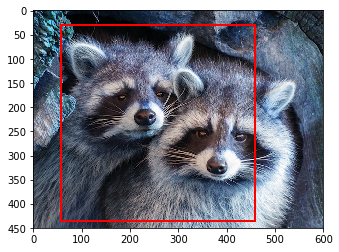

In [97]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()